# 02_Analysis of POS Balance
In this notebook I analyze the pos cash balance dataset which is described below:
- Monthly balance snapshots of previous point of sales (POS) and cash loans that the applicant had with Home Credit

**Analysis Summary**:
After analyzing the pos cash balance dataset I created a vector for each loan id with following columns:
- COMPLETED_COUNT: The number of completed accounts by bin size of 5( i.e. 1 means 0 to 5 accounts).
- OVERDUE_ACTIVE_COUNT: Flag to indicate if a client has an overdue account.

I also created an aggregate table of four functions ('minimum', 'maximum', 'mean','standard deviation') SK_ID_CURR for each of the availble float64 fields. Each field would have a new column for each of the functions. This created a total of 20 features. By taking this approach I figure there will be many fields available during model selection that can be removed if there feature importance is zero.

In [1]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

## 2.1 Import Datasets And Overview data

In [2]:
pos = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\POS_CASH_balance.csv")
FieldsNames = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\HomeCredit_columns_description.csv")

In [3]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
# print description of each field in the table
Info = FieldsNames[FieldsNames['Table'] == 'POS_CASH_balance.csv'] [['Row','Description']]
for i in Info.values.tolist():
    print (i,"\n", "-"*100)

In [5]:
pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [6]:
num_col = pos.select_dtypes(["float", "integer"]).columns

In [7]:
pos[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,10001358.0,1.903217e+06,535846.530722,1000001.0,1434405.0,1896565.0,2368963.0,2843499.0
SK_ID_CURR,10001358.0,2.784039e+05,102763.745090,100001.0,189550.0,278654.0,367429.0,456255.0
MONTHS_BALANCE,10001358.0,-3.501259e+01,26.066570,-96.0,-54.0,-28.0,-13.0,-1.0
CNT_INSTALMENT,9975287.0,1.708965e+01,11.995056,1.0,10.0,12.0,24.0,92.0
CNT_INSTALMENT_FUTURE,9975271.0,1.048384e+01,11.109058,0.0,3.0,7.0,14.0,85.0
SK_DPD,10001358.0,1.160693e+01,132.714043,0.0,0.0,0.0,0.0,4231.0
SK_DPD_DEF,10001358.0,6.544684e-01,32.762491,0.0,0.0,0.0,0.0,3595.0


In [8]:
cat_col = pos.select_dtypes(["object"]).columns

In [9]:
pos[cat_col].describe().T

,count,unique,top,freq
NAME_CONTRACT_STATUS,10001358,9,Active,9151119


---------------------------------------------------------------------------------------------------- 
 NAME_CONTRACT_STATUS


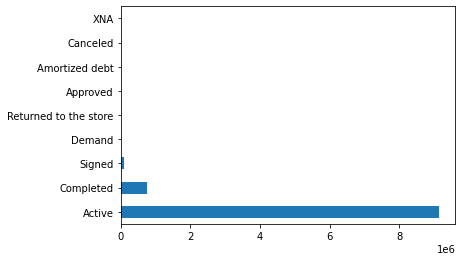

In [10]:
for i in cat_col:
    print("-"*100,"\n",i)
    pos[i].value_counts().plot.barh()
    plt.show()

## 2.2 Filter Dataset
Get the most recent record by SK_ID_CURR and SK_ID_PREV.

In [11]:
pos_filter = pos.sort_values(by=['MONTHS_BALANCE']).groupby(['SK_ID_CURR', 'SK_ID_PREV']).last().copy().reset_index()

In [12]:
pos_filter.head()

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,100001,1369693,-53,4.0,0.0,Completed,0,0
1,100001,1851984,-93,4.0,0.0,Completed,0,0
2,100002,1038818,-1,24.0,6.0,Active,0,0
3,100003,1810518,-18,7.0,0.0,Completed,0,0
4,100003,2396755,-66,12.0,1.0,Active,0,0


## 1.3 Count Completed Installments
Count the number of completed installments loans by id.

In [13]:
def completed(df):
    name_flag = 'COMPLETED_FLAG'
    name = 'COMPLETED_COUNT'

    df[name_flag] = df['NAME_CONTRACT_STATUS'].apply(lambda x: 1 if x =='Completed' else 0)
    
    df[name] = df.groupby('SK_ID_CURR')[name_flag].transform('sum')
    
    #lets increase the groups by 1 to make the base group 1
    df[name] = df[name].apply(lambda x:x+1)
    
    #drop column
    df.drop([name_flag],axis=1, inplace=True)

#apply function
completed(pos_filter)

In [14]:
pos_filter.groupby('COMPLETED_COUNT').size()

COMPLETED_COUNT
1      43931
2     182962
3     204546
4     168290
5     121485
6      81498
7      51484
8      31915
9      20122
10     11855
11      7118
12      4094
13      2875
14      1671
15       945
16       572
17       369
18       264
19       177
20        19
21        62
22        45
25        26
dtype: int64

## 2.4 Count Overdue Active Counts
Count the number of overdue active installments loans by id.

In [15]:
def over_due_active(df):
    ''' Count the number of overdue active accounts'''
    
    name_flag = 'OVERDUE_FLAG'
    name = 'OVERDUE_ACTIVE_COUNT'
    
    def fun(x):
        over = x['SK_DPD_DEF']
        future_cnt = x['CNT_INSTALMENT_FUTURE']
                       
        if over > 0 and future_cnt > 0:
            return 1
        else:
            return 0

    df[name_flag] = df.apply(fun,axis=1)
    
    df[name] = df.groupby('SK_ID_CURR')[name_flag].transform('sum')
    
    #lets increase the groups by 1 to make the base group 1
    df[name] = df[name].apply(lambda x:x+1)
    
    #drop column
    df.drop([name_flag],axis=1, inplace=True)

#apply function
over_due_active(pos_filter)

In [16]:
pos_filter.head()

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,COMPLETED_COUNT,OVERDUE_ACTIVE_COUNT
0,100001,1369693,-53,4.0,0.0,Completed,0,0,3,1
1,100001,1851984,-93,4.0,0.0,Completed,0,0,3,1
2,100002,1038818,-1,24.0,6.0,Active,0,0,1,1
3,100003,1810518,-18,7.0,0.0,Completed,0,0,3,1
4,100003,2396755,-66,12.0,1.0,Active,0,0,3,1


In [17]:
pos_filter.groupby('OVERDUE_ACTIVE_COUNT').size()

OVERDUE_ACTIVE_COUNT
1    930577
2      5172
3       450
4       110
5        16
dtype: int64

## 2.5 Create Aggregate Dataset

In [18]:
#let get minimum, maximum, average and standard deviation
fun_agg = ['min', 'max', 'mean','std']

agg_fun_df = pos.groupby('SK_ID_CURR')[num_col[3:]].agg(fun_agg)

#rename columns
agg_fun_df.columns = ["{}_{}".format(c[0],c[1].upper()) for c in agg_fun_df.columns.values.tolist()] 

#let fill nan values
agg_fun_df.fillna(0,inplace=True)
agg_fun_df.reset_index(inplace=True)

In [19]:
agg_fun_df.head()

,SK_ID_CURR,CNT_INSTALMENT_MIN,CNT_INSTALMENT_MAX,CNT_INSTALMENT_MEAN,CNT_INSTALMENT_STD,CNT_INSTALMENT_FUTURE_MIN,CNT_INSTALMENT_FUTURE_MAX,CNT_INSTALMENT_FUTURE_MEAN,CNT_INSTALMENT_FUTURE_STD,SK_DPD_MIN,SK_DPD_MAX,SK_DPD_MEAN,SK_DPD_STD,SK_DPD_DEF_MIN,SK_DPD_DEF_MAX,SK_DPD_DEF_MEAN,SK_DPD_DEF_STD
0,100001,4.0,4.0,4.000000,0.000000,0.0,4.0,1.444444,1.424001,0,7,0.777778,2.333333,0,7,0.777778,2.333333
1,100002,24.0,24.0,24.000000,0.000000,6.0,24.0,15.000000,5.627314,0,0,0.000000,0.000000,0,0,0.000000,0.000000
2,100003,6.0,12.0,10.107143,2.806597,0.0,12.0,5.785714,3.842811,0,0,0.000000,0.000000,0,0,0.000000,0.000000
3,100004,3.0,4.0,3.750000,0.500000,0.0,4.0,2.250000,1.707825,0,0,0.000000,0.000000,0,0,0.000000,0.000000
4,100005,9.0,12.0,11.700000,0.948683,0.0,12.0,7.200000,3.614784,0,0,0.000000,0.000000,0,0,0.000000,0.000000


## 2.6 Select Final Features and Merge Datasets
Select the COMPLETED_COUNT, OVERDUE_ACTIVE_COUNT and all from aggregate table as final features.

In [20]:
features= ['COMPLETED_COUNT','OVERDUE_ACTIVE_COUNT']

In [21]:
pos_final = pos_filter.groupby('SK_ID_CURR').first()[features].reset_index()

In [22]:
def applyMax(feature,df):
    """ Lets set a ceiling value.
    """ 
    column = df[feature].value_counts(normalize=True).reset_index() 
    df[feature] = np.clip(df[feature], 1, column[column[feature]>0.001]['index'].max()) #setting ceiling value

In [23]:
#set max values
for i in features:
    applyMax(i, pos_final)

In [24]:
pos_final = pos_final.merge(agg_fun_df,
                            how='left', 
                            on='SK_ID_CURR',
                            validate='one_to_one')

In [25]:
pos_final.groupby('OVERDUE_ACTIVE_COUNT').size()

OVERDUE_ACTIVE_COUNT
1    335764
2      1488
dtype: int64

In [26]:
pos_final.groupby('COMPLETED_COUNT').size()

COMPLETED_COUNT
1      37041
2     122019
3      78201
4      45111
5      25111
6      13738
7       7333
8       3933
9       2184
10      1155
11      1426
dtype: int64

---------------------------------------------------------------------------------------------------- 
 COMPLETED_COUNT


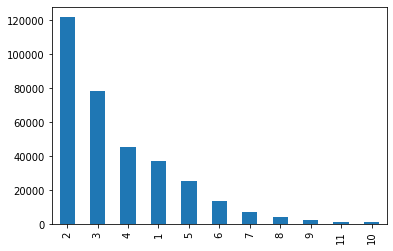

---------------------------------------------------------------------------------------------------- 
 OVERDUE_ACTIVE_COUNT


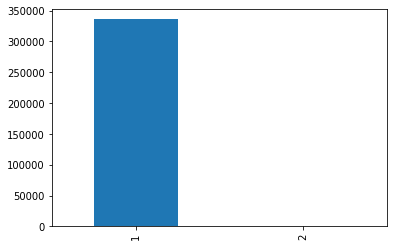

In [27]:
for i in features:
    print("-"*100,"\n",i)
    pos_final[i].value_counts().plot.bar()
    plt.show()

## 2.7 Save Final Dataset To File

In [28]:
# rename columns append all fields with 'POS_BAL_' except id field
col_name = []
for c in pos_final.columns:
    if c =='SK_ID_CURR':
        col_name.append(c)
    else:
        col_name.append("POS_BAL_"+c)

pos_final.columns = col_name

In [30]:
pos_final.to_csv(r'C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\results\1_2_pos_balances.csv',index=False)
print("File was saved.")

File was saved.
